<a href="https://colab.research.google.com/github/gopala-03/gopala-03/blob/main/TC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Classification**

# **PART 1**

# Installing TensorFlow and TensorFlow Model Garden

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.14.0


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
!pip install -Uqr models/official/requirements.txt

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install tensorflow-text

## Downloading and Importing the **Quora Insincere Questions** Dataset

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')

In [ ]:
from official.nlp.data import classifier_data_lib
from official.nlp import optimization
import tensorflow_text as text

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.14.0
Eager mode:  True
Hub version:  0.15.0
GPU is available


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install --upgrade numpy

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression = 'zip', low_memory = False)
df.shape

(1306122, 3)

In [ ]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

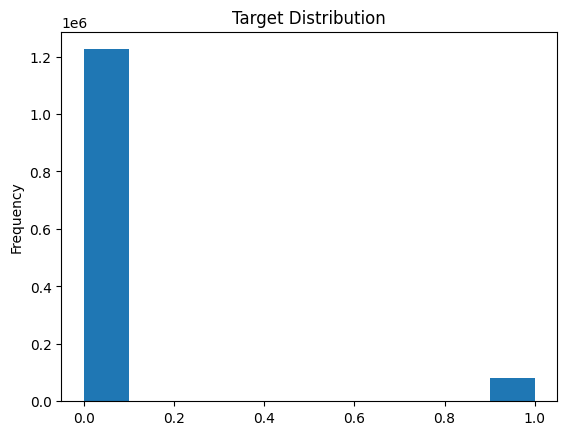

In [ ]:
# target label distribution
df.target.plot(kind='hist', title="Target Distribution")

## Creating Data for Training and Evaluation

In [ ]:
train_df, remaining = train_test_split(df, random_state = 42, train_size = 0.0075, stratify = df['target'])
val_df, _ = train_test_split(remaining, random_state=42, train_size = 0.00075, stratify = remaining['target'])

print(train_df.shape, val_df.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

(9795, 3) (972, 3)


In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  val_data = tf.data.Dataset.from_tensor_slices((val_df['question_text'].values, val_df['target'].values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


# Downloading the **Pre-trained BERT Model** from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

# Label categories
label_list = [0, 1]

# maximum length of (token) input sequences
max_seq_length = 128  # default max length

train_batch_size = 32

In [ ]:
bert_layer = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
tokenizer = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_tokenizer = hub.load(tokenizer)

bert_tokenizer.tokenize(['hi, how are you doing?'])

<tf.RaggedTensor [[[7632],
  [1010],
  [2129],
  [2024],
  [2017],
  [2725],
  [1029]]]>

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

preprocessor = hub.KerasLayer(tokenizer)
encoder_inputs = preprocessor(text_input)

preprocess_model = tf.keras.Model(text_input, encoder_inputs)

preprocess_model(tf.constant(['hi, how are you doing?']))

{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

# Creating a TensorFlow Input Pipeline

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = train_data.shuffle(1000).batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

  # valid
  val_data = val_data.batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
train_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

In [ ]:
val_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

# Adding a Classification Head to the BERT Layer

In [ ]:
def create_model():

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'inputs')

  preprocessor = hub.KerasLayer(tokenizer)
  encoder_inputs = preprocessor(text_input)

  encoder = hub.KerasLayer(bert_layer, trainable=True, name = 'BERT_Encoder')
  outputs = encoder(encoder_inputs)

  pooled_output = outputs['pooled_output']

  batch_norm = tf.keras.layers.BatchNormalization()(pooled_output)
  drop = tf.keras.layers.Dropout(0.4)(batch_norm)
  fc = tf.keras.layers.Dense(128, activation='relu')(drop)
  final_output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(fc)

  return tf.keras.Model(text_input, final_output)

# **Fine-Tuning BERT** for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None,)]                    0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  {'input_type_ids': (None,    0         ['inputs[0][0]']              
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [ ]:
# Train model
epochs = 3
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/3
306/306 [==============================] - 329s 920ms/step - loss: 0.3533 - binary_accuracy: 0.8530 - val_loss: 0.1885 - val_binary_accuracy: 0.9396
Epoch 2/3
306/306 [==============================] - 279s 913ms/step - loss: 0.1583 - binary_accuracy: 0.9419 - val_loss: 0.1592 - val_binary_accuracy: 0.9542
Epoch 3/3
306/306 [==============================] - 289s 946ms/step - loss: 0.1186 - binary_accuracy: 0.9581 - val_loss: 0.1727 - val_binary_accuracy: 0.9573


# **Evaluating** the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

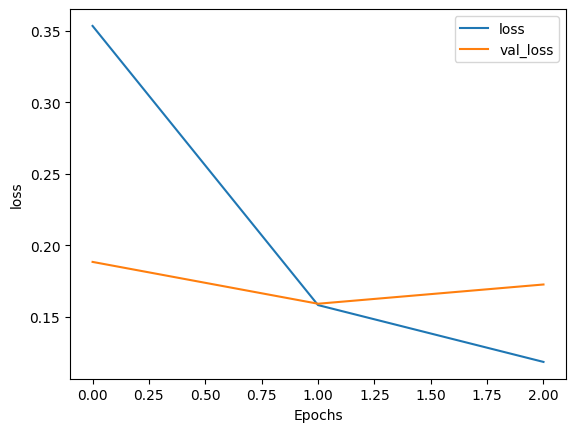

In [ ]:
plot_graphs(history=history, metric='loss')

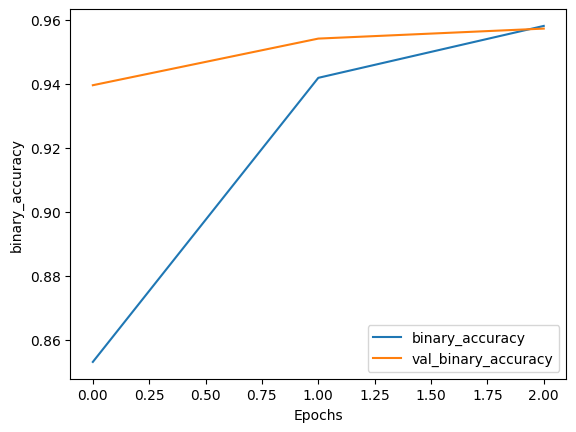

In [ ]:
plot_graphs(history,'binary_accuracy')

# **Testing**

In [ ]:
# testing on some samples
sample_example = ["Do you have an adopted dog, how would you encourage people to adopt and not shop?"]
model.predict(sample_example)

1/1 [==============================] - 1s 829ms/step


array([[0.00304392]], dtype=float32)

In [ ]:
sample_example = ["HWhy do Europeans say they're the superior race, when in fact it took them over 2,000 years until mid 19th century to surpass China's largest economy?"]
model.predict(sample_example)

1/1 [==============================] - 0s 41ms/step


array([[0.5579501]], dtype=float32)

# **PART 2**

# **Without Zero-Shot and Few-Shot Learning**

In [ ]:
# Testing on some samples
sample_examples = [
    "Do you think the zyxyzon flux capacitor is compatible with the hyperspace drive system?",
    "This is a test sentence for shot classification",
    "This is a random sentence with a mix of words and no clear sentiment.",
    "Hello?",
]

In [ ]:
# Iterate through the sample examples
for text_example in sample_examples:
    # Predict the class probabilities for the example
    predicted_probabilities = model.predict([text_example])[0][0]

    classified_result = "Positive" if predicted_probabilities >= 0.5 else "Negative"

    print("Original Text: ", text_example)
    print("Classified Result: ", classified_result)
    print("Predicted Probabilities: ", predicted_probabilities)
    print()

# **Incorporating Zero-Shot Learning Technique**

In [ ]:
   !pip install transformers

In [ ]:
from transformers import pipeline

zero_shot_classifier = pipeline("zero-shot-classification")

In [ ]:
for text_example in sample_examples:
    classification = zero_shot_classifier(text_example, candidate_labels=["Positive", "Negative"])

    max_score_label = classification['labels'][0]
    max_score = classification['scores'][0]

    if max_score < 0.5:
        classified_result = "New Label"
    else:
        classified_result = max_score_label

    print("Original Text: ", text_example)
    print("Classified Result: ", classified_result)
    print("Max Score Label: ", max_score_label)
    print("Max Score: ", max_score)
    print()


#**Comparision**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Sample text examples
sample_examples = [
    "This is a positive statement.",
    "This is a negative statement.",
]

# True classification labels for the sample examples
true_labels = ["Positive", "Negative"]

# Initialize lists to store model predictions
predictions_without_zero_shot_few_shot = []
predictions_with_zero_shot = []

# Iterate through the sample examples
for text_example in sample_examples:
    # Predict the class probabilities without zero-shot learning
    predicted_probabilities = model.predict([text_example])[0][0]
    classified_result_without_zero_shot_few_shot = "Positive" if predicted_probabilities >= 0.5 else "Negative"
    predictions_without_zero_shot_few_shot.append(classified_result_without_zero_shot_few_shot)

    # Classify the example using zero-shot learning
    classification = zero_shot_classifier(text_example, candidate_labels=["Positive", "Negative"])
    max_score_label = classification['labels'][0]
    classified_result_with_zero_shot = max_score_label
    predictions_with_zero_shot.append(classified_result_with_zero_shot)

# Compute evaluation metrics
accuracy_without_zero_shot_few_shot = accuracy_score(true_labels, predictions_without_zero_shot_few_shot)
precision_without_zero_shot_few_shot = precision_score(true_labels, predictions_without_zero_shot_few_shot, average='weighted')
recall_without_zero_shot_few_shot = recall_score(true_labels, predictions_without_zero_shot_few_shot, average='weighted')
f1_score_without_zero_shot_few_shot = f1_score(true_labels, predictions_without_zero_shot_few_shot, average='weighted')

accuracy_with_zero_shot = accuracy_score(true_labels, predictions_with_zero_shot)
precision_with_zero_shot = precision_score(true_labels, predictions_with_zero_shot, average='weighted')
recall_with_zero_shot = recall_score(true_labels, predictions_with_zero_shot, average='weighted')
f1_score_with_zero_shot = f1_score(true_labels, predictions_with_zero_shot, average='weighted')

# Print the evaluation metrics
print("Without Zero-Shot Learning:")
print("Accuracy:", accuracy_without_zero_shot_few_shot)
print("Precision:", precision_without_zero_shot_few_shot)
print("Recall:", recall_without_zero_shot_few_shot)
print("F1 Score:", f1_score_without_zero_shot_few_shot)

print("\nWith Zero-Shot Learning:")
print("Accuracy:", accuracy_with_zero_shot)
print("Precision:", precision_with_zero_shot)
print("Recall:", recall_with_zero_shot)
print("F1 Score:", f1_score_with_zero_shot)


# **Visualising**

In [ ]:
import matplotlib.pyplot as plt

model_names = ["Base Model", "With Zero-Shot"]
accuracies = [accuracy_without_zero_shot_few_shot, accuracy_with_zero_shot]
precisions = [precision_without_zero_shot_few_shot, precision_with_zero_shot]
recalls = [recall_without_zero_shot_few_shot, recall_with_zero_shot]
f1_scores = [f1_score_without_zero_shot_few_shot, f1_score_with_zero_shot]

plt.figure(figsize=(5, 5))
plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy between Models')
plt.show()

plt.figure(figsize=(5, 5))
plt.bar(model_names, precisions, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Comparison of Precision between Models')
plt.show()

plt.figure(figsize=(5, 5))
plt.bar(model_names, recalls, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Comparison of Recall between Models')
plt.show()

plt.figure(figsize=(5, 5))
plt.bar(model_names, f1_scores, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Score between Models')
plt.show()


# Incorporating **Few-Shot Learning** Technique

In [ ]:
def few_shot_classification(text_example, labels, model_name="facebook/bart-large-mnli"):
    classifier = pipeline("zero-shot-classification", model=model_name)
    result = classifier(text_example, labels)

    # Extract the most probable label and its score
    max_score_label = result['labels'][0]
    max_score = result['scores'][0]

    # If the maximum score is below a certain threshold, classify it as "New Label"
    threshold = 0.5
    classified_result = max_score_label if max_score >= threshold else "New Label"

    return classified_result, max_score_label, max_score


In [ ]:
# Sample text examples
sample_examples = [
    "Do you think the zyxyzon flux capacitor is compatible with the hyperspace drive system?",
    "This is a test sentence for shot classification.",
    "This is a random sentence with a mix of words and no clear sentiment.",
    "Hello?"
]

# Candidate labels for few-shot classification
candidate_labels = ["Positive", "Negative"]

# Iterate through the sample examples
for text_example in sample_examples:
    classified_result, max_score_label, max_score = few_shot_classification(text_example, candidate_labels)

    # Print the original text and the classified result
    print("Original Text: ", text_example)
    print("Classified Result: ", classified_result)
    print("Max Score Label: ", max_score_label)
    print("Max Score: ", max_score)
    print()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Sample text examples
sample_examples = [
    "This is a positive statement.",
    "This is a negative statement.",
]

few_shot_classifier = pipeline("zero-shot-classification")

# True classification labels for the sample examples
true_labels = ["Positive", "Negative"]

# Initialize lists to store model predictions
predictions_without_zero_shot_few_shot = []
predictions_with_few_shot = []

# Iterate through the sample examples
for text_example in sample_examples:
    # Predict the class probabilities without zero-shot learning
    predicted_probabilities = model.predict([text_example])[0][0]
    classified_result_without_zero_shot_few_shot = "Positive" if predicted_probabilities >= 0.5 else "Negative"
    predictions_without_zero_shot_few_shot.append(classified_result_without_zero_shot_few_shot)


    # Classify the example using few-shot learning (few-shot model)
    classification = few_shot_classifier(text_example, candidate_labels=["Positive", "Negative"])
    classified_result_with_few_shot = classification['labels'][0]
    predictions_with_few_shot.append(classified_result_with_few_shot)

# Compute evaluation metrics
accuracy_without_zero_shot_few_shot = accuracy_score(true_labels, predictions_without_zero_shot_few_shot)
precision_without_zero_shot_few_shot = precision_score(true_labels, predictions_without_zero_shot_few_shot, average='weighted')
recall_without_zero_shot_few_shot = recall_score(true_labels, predictions_without_zero_shot_few_shot, average='weighted')
f1_score_without_zero_shot_few_shot = f1_score(true_labels, predictions_without_zero_shot_few_shot, average='weighted')

# Calculate evaluation metrics for the few-shot model
accuracy_with_few_shot = accuracy_score(true_labels, predictions_with_few_shot)
precision_with_few_shot = precision_score(true_labels, predictions_with_few_shot, average='weighted')
recall_with_few_shot = recall_score(true_labels, predictions_with_few_shot, average='weighted')
f1_score_with_few_shot = f1_score(true_labels, predictions_with_few_shot, average='weighted')


# Print the evaluation metrics
print("Without Zero-Shot and Few-Shot Learning:")
print("Accuracy:", accuracy_without_zero_shot_few_shot)
print("Precision:", precision_without_zero_shot_few_shot)
print("Recall:", recall_without_zero_shot_few_shot)
print("F1 Score:", f1_score_without_zero_shot_few_shot)

print("\nWith Few-Shot Learning:")
print("Accuracy:", accuracy_with_few_shot)
print("Precision:", precision_with_few_shot)
print("Recall:", recall_with_few_shot)
print("F1 Score:", f1_score_with_few_shot)

In [ ]:
import matplotlib.pyplot as plt

# Define the evaluation metrics for both models
model_names = ["Base Model", "With Zero-Shot", "With Few-Shot"]
accuracies = [accuracy_without_zero_shot_few_shot, accuracy_with_zero_shot, accuracy_with_few_shot]
precisions = [precision_without_zero_shot_few_shot, precision_with_zero_shot, precision_with_few_shot]
recalls = [recall_without_zero_shot_few_shot, recall_with_zero_shot, recall_with_few_shot]
f1_scores = [f1_score_without_zero_shot_few_shot, f1_score_with_zero_shot, f1_score_with_few_shot]

# Create a bar plot to compare accuracy
plt.figure(figsize=(5, 5))
plt.plot(model_names, accuracies, marker='o', linestyle='-')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy between Models')
plt.grid(True)
plt.show()

# Create a bar plot to compare precision
plt.figure(figsize=(5, 5))
plt.plot(model_names, precisions, marker='o', linestyle='-')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Comparison of Precision between Models')
plt.grid(True)
plt.show()

# Create a bar plot to compare recall
plt.figure(figsize=(5, 5))
plt.plot(model_names, recalls, marker='o', linestyle='-')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Comparison of Recall between Models')
plt.grid(True)
plt.show()

# Create a bar plot to compare F1 Score
plt.figure(figsize=(5, 5))
plt.plot(model_names, f1_scores, marker='o', linestyle='-')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Score between Models')
plt.grid(True)
plt.show()
